In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.kuka.reaching import KukaReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [5]:
savepath = parentdir + '/data/kuka/'

In [6]:
# data_train = np.load(savepath+'data_pd_reg.npy')
# task = KukaReaching(render=True)
# task.visualize_training_data(data_train, 0)

In [7]:
task = KukaReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub
v_lb, v_ub = -100 * torch.ones_like(q_lb), 100 * torch.ones_like(q_ub)

In [8]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.pd import PD

na = 14
gain_ub = torch.Tensor([30, 15, 30, 30, 5, 3, 0.1])
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(PD(nx, nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor

In [9]:
# Setup model learning

from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nx, nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size, 
                                 learning_rate = 0.001)

dynamics.state_lb = torch.cat((q_lb, v_lb))
dynamics.state_ub = torch.cat((q_ub, v_ub))

In [10]:
# Setup controller

from stage.controllers.pets import PETS

plan_horizon = 30
n_particles = 10
pop_size = 400
assert n_particles % ensemble_size == 0

controller = PETS(dynamics, task.cost, actor,
                  plan_horizon, n_particles, pop_size)

In [11]:
# Setup learner
from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [12]:
controller.regularize(0)
_ = learner.learn(30, verbose=True)
learner.save_training_data(savepath+'data_pd_noreg')

Network training: 100%|██████████| 10/10 [00:00<00:00, 29.34epoch(s)/s, Training loss MSE=23.5339] 


Iteration:  0
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.012342753410339356
obs. reward:  -279.64832
act. reward:  -1.7499437


Network training: 100%|██████████| 10/10 [00:01<00:00,  9.97epoch(s)/s, Training loss MSE=20.05048]


Iteration:  1
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26130568822224937
obs. reward:  -282.10986
act. reward:  -1.5234623


Network training: 100%|██████████| 10/10 [00:01<00:00,  6.73epoch(s)/s, Training loss MSE=11.342446]


Iteration:  2
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26160110473632814
obs. reward:  -249.71628
act. reward:  -0.52487886


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.30epoch(s)/s, Training loss MSE=7.3103333]


Iteration:  3
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26124649365743
obs. reward:  -279.97815
act. reward:  -0.0070799887


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.24epoch(s)/s, Training loss MSE=7.175061]


Iteration:  4
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26103695869445803
obs. reward:  -181.54797
act. reward:  -1.8652815


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.51epoch(s)/s, Training loss MSE=5.342293]


Iteration:  5
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.25910104751586915
obs. reward:  -205.82088
act. reward:  -0.061313137


Network training: 100%|██████████| 10/10 [00:03<00:00,  3.07epoch(s)/s, Training loss MSE=5.172045]


Iteration:  6
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26102469603220624
obs. reward:  -155.31212
act. reward:  -1.4700475


Network training: 100%|██████████| 10/10 [00:03<00:00,  2.69epoch(s)/s, Training loss MSE=13.843928]


Iteration:  7
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2605761178334554
obs. reward:  -179.61441
act. reward:  -8.584873


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.40epoch(s)/s, Training loss MSE=12.788741]


Iteration:  8
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26097687244415285
obs. reward:  -210.018
act. reward:  -2.4530802


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.25epoch(s)/s, Training loss MSE=10.683137]


Iteration:  9
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26092476685841876
obs. reward:  -109.38862
act. reward:  -0.6748818


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.97epoch(s)/s, Training loss MSE=11.145324]


Iteration:  10
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26237809816996255
obs. reward:  -292.02197
act. reward:  -3.82729


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.79epoch(s)/s, Training loss MSE=9.839117] 


Iteration:  11
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26215052127838134
obs. reward:  -148.08492
act. reward:  -2.7189646


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.71epoch(s)/s, Training loss MSE=8.737901]


Iteration:  12
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2604192638397217
obs. reward:  -306.16656
act. reward:  -2.087233


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.55epoch(s)/s, Training loss MSE=8.4179325]


Iteration:  13
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26096133232116697
obs. reward:  -113.94672
act. reward:  -1.7187912


Network training: 100%|██████████| 10/10 [00:06<00:00,  1.44epoch(s)/s, Training loss MSE=12.172132]


Iteration:  14
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2600524679819743
obs. reward:  -211.06969
act. reward:  -3.0735517


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.36epoch(s)/s, Training loss MSE=15.486239]


Iteration:  15
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2616649039586385
obs. reward:  -215.24014
act. reward:  -3.4077096


Network training: 100%|██████████| 10/10 [00:07<00:00,  1.28epoch(s)/s, Training loss MSE=14.129692]


Iteration:  16
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26016956329345703
obs. reward:  -177.00272
act. reward:  -1.7828971


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.20epoch(s)/s, Training loss MSE=16.049286]


Iteration:  17
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2596958605448405
obs. reward:  -131.07227
act. reward:  -5.7037992


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.13epoch(s)/s, Training loss MSE=15.93432]


Iteration:  18
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26144141832987466
obs. reward:  -287.78284
act. reward:  -5.509877


Network training: 100%|██████████| 10/10 [00:08<00:00,  1.15epoch(s)/s, Training loss MSE=15.388432]


Iteration:  19
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2604437843958537
obs. reward:  -175.66324
act. reward:  -0.51710105


Network training: 100%|██████████| 10/10 [00:09<00:00,  1.10epoch(s)/s, Training loss MSE=15.498592]


Iteration:  20
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26040332158406576
obs. reward:  -114.73421
act. reward:  -0.02934454


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.02s/epoch(s), Training loss MSE=17.650991]


Iteration:  21
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2611281410853068
obs. reward:  -208.32309
act. reward:  -8.76888


Network training: 100%|██████████| 10/10 [00:10<00:00,  1.06s/epoch(s), Training loss MSE=16.97393]


Iteration:  22
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2622493823369344
obs. reward:  -99.23766
act. reward:  -1.925772


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.10s/epoch(s), Training loss MSE=18.470028]


Iteration:  23
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2617782179514567
obs. reward:  -86.55008
act. reward:  -6.0025735


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.15s/epoch(s), Training loss MSE=19.075754]


Iteration:  24
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2627734073003133
obs. reward:  -88.86068
act. reward:  -1.9812266


Network training: 100%|██████████| 10/10 [00:11<00:00,  1.19s/epoch(s), Training loss MSE=20.554245]


Iteration:  25
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26199796676635745
obs. reward:  -97.490005
act. reward:  -2.1112874


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.23s/epoch(s), Training loss MSE=22.304195]


Iteration:  26
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2621770175298055
obs. reward:  -84.46331
act. reward:  -2.349649


Network training: 100%|██████████| 10/10 [00:12<00:00,  1.29s/epoch(s), Training loss MSE=23.442163]


Iteration:  27
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26316978136698405
obs. reward:  -73.88479
act. reward:  -1.8955755


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.31s/epoch(s), Training loss MSE=22.649918]


Iteration:  28
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.2601925245920817
obs. reward:  -73.50773
act. reward:  -2.3024523


Network training: 100%|██████████| 10/10 [00:13<00:00,  1.38s/epoch(s), Training loss MSE=22.717104]

Iteration:  29
Initial state:  tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
avg. decision time:  0.26277713616689047
obs. reward:  -104.37855
act. reward:  -2.0880954


In [13]:
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.26149718443552655
obs. reward:  -106.4597
act. reward:  -4.2274933


In [14]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(142.1305, grad_fn=<MeanBackward0>)
tensor(171.2377, grad_fn=<StdBackward0>)


In [15]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

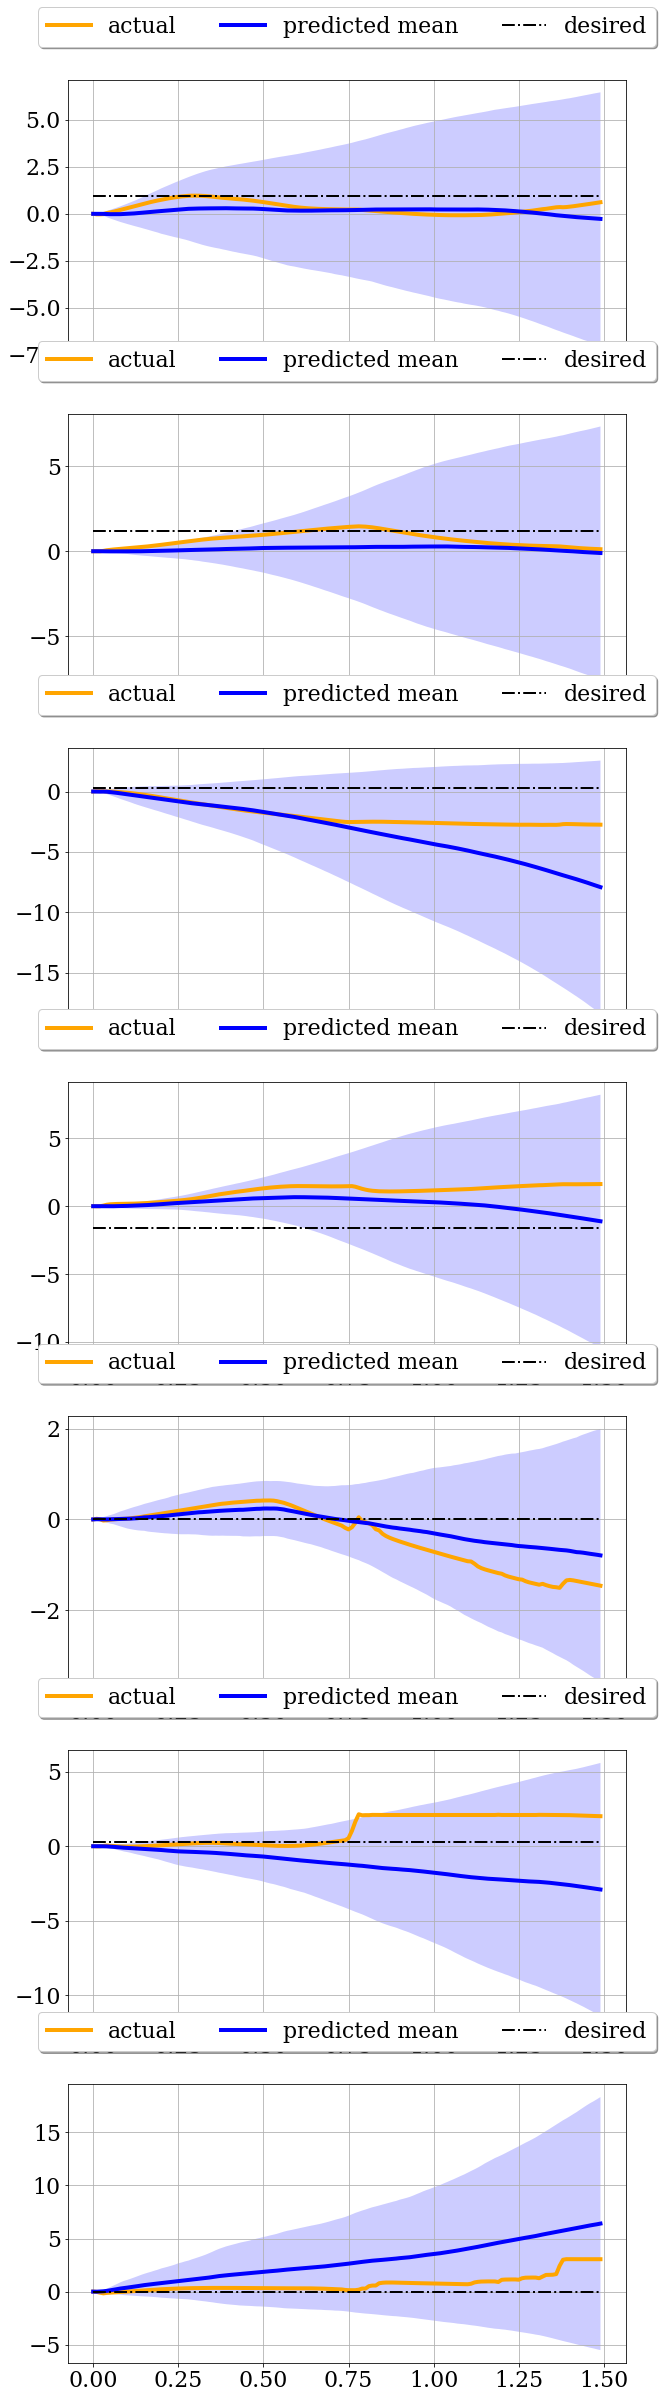

In [16]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
dlb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax[i].plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax[i].plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
    ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax[i].fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax[i].grid()
#     _ = ax[i].set_ylim([-3.2, 3.2])
    ax[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')